In [1]:
import os
import math
import tqdm
import time
import pickle
from collections import Counter

import re

def tokenize_string(s):
    # Split by spaces and punctuation, but keep hyphenated words intact
    tokens = re.findall(r'\b\w+(?:-\w+)*\b|[^\w\s]', s)
    return tokens

def dash_recovery(input_tokenized, tokenized):
    toknied = []
    for tok, num in zip(input_tokenized, tokenized[1:-1]):
        if num == 3 and "-" in tok: # unk
            tok = tok.replace('-', ' - ')
            toknied.extend(tok.split())
        else:
            toknied.append(tok)
    return toknied

def res_parser(seq, label):
    res = dict()
    for i in range(len(seq)):
        if label[i] == 'O':
            continue
        if label[i] not in res:
            res[label[i]] = list()
        res[label[i]].append(seq[i])
    return res

from datasets import load_dataset, load_from_disk

# https://github.com/Babelscape/multinerd
# https://huggingface.co/datasets/Babelscape/multinerd

# dataset = load_dataset("Babelscape/multinerd")

def en_fil(x):
    return x["lang"] == "en"

en_paths = {
    'train' : 'en_train',
    'val'   : 'en_validation',
    'test'  : 'en_test'
}

# en_dataset = {
#     'train' : dataset['train'].filter(en_fil, num_proc=8).select,
#     'val'   : dataset['validation'].filter(en_fil, num_proc=8).select,
#     'test'  : dataset['test'].filter(en_fil, num_proc=8).select
# }

en_dataset_vars = {}

for key, val in en_paths.items():
    if not os.path.isdir(val):
        dete = en_dataset[key]
        dete.save_to_disk(val)
        en_dataset_vars[key] = dete
    else:
        en_dataset_vars[key] = load_from_disk(val)
        
# for key, val in en_dataset_vars.items():
#     en_dataset_vars[key] = val.select(range(1000))

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)
def plot_training(losses, title='Loss over time'):
    clear_output(wait=True)
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

from transformers import  AutoTokenizer

repo = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(repo)

def reverse_dict(inp_dict: dict):
    return {v:k for k,v in inp_dict.items()}

# special_tok_ids = {k: [tokenizer.convert_tokens_to_ids(v), v] for k, v in tokenizer.special_tokens_map.items()}

# special_tok_itos = {tokenizer.convert_tokens_to_ids(v): v for k, v in tokenizer.special_tokens_map.items()}
# special_tok_stoi = reverse_dict(special_tok_itos)

gen = torch.Generator()
gen.manual_seed(0)

label_to_i = {
    "O": 0,
    "B-PER": 1,     # Person                (PER)
    "I-PER": 2,     
    "B-ORG": 3,     # Location              (LOC)
    "I-ORG": 4,     
    "B-LOC": 5,     # Organization          (ORG)
    "I-LOC": 6,     
    "B-ANIM": 7,    # Animal                (ANIM)
    "I-ANIM": 8,    
    "B-BIO": 9,     # Biological entity     (BIO)
    "I-BIO": 10,    
    "B-CEL": 11,    # Celestial Body        (CEL)
    "I-CEL": 12,    
    "B-DIS": 13,    # Disease               (DIS)
    "I-DIS": 14,    
    "B-EVE": 15,    # Event                 (EVE)
    "I-EVE": 16,    
    "B-FOOD": 17,   # Food                  (FOOD)
    "I-FOOD": 18,   
    "B-INST": 19,   # Instrument            (INST)
    "I-INST": 20,
    "B-MEDIA": 21,  # Media                 (MEDIA)
    "I-MEDIA": 22,
    "B-MYTH": 23,   # Mythological entity   (MYTH)
    "I-MYTH": 24,
    "B-PLANT": 25,  # Plant                 (PLANT)
    "I-PLANT": 26,
    "B-TIME": 27,   # Time                  (TIME)
    "I-TIME": 28,
    "B-VEHI": 29,   # Vehicle               (VEHI)
    "I-VEHI": 30,
  }
i_to_label = reverse_dict(label_to_i)

cuda


e:\ProgramData\anaconda3\envs\cute\lib\site-packages\transformers\utils\hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        # Int to String
        # Special tokens
        self.itos = {
            0:"<s>", 
            1:"<pad>", 
            2:"</s>", 
            3:"<unk>"
        }
        
        # String to Int
        self.stoi = self.reverse_dict(self.itos)
        
        self.freq_threshold = freq_threshold
        self.frequencies = None
        
    def __len__(self): 
        return len(self.itos)
    
    @staticmethod
    def reverse_dict(inp_dict: dict):
        return {v:k for k,v in inp_dict.items()}
    
    def build_vocab(self, dataset_train, dataset_test, dataset_val):
        frequencies = Counter()
        idx = 4
        
        sequences = dataset_train['tokens']
        sequences.extend(dataset_test['tokens'])
        sequences.extend(dataset_val['tokens'])
        sequences = sorted(sequences)
        len_inp = len(sequences)
        print(f"Received: {len_inp} sentences")
        for seq in sequences:
            for word in seq:
                frequencies[word] += 1
                # add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
        self.frequencies = frequencies
        
def numericalize_list(word_list: list[str], vocab: 'Vocabulary'):
    tokens = [vocab.stoi['<s>']]
    
    for word in word_list:
        if word in vocab.stoi:
            tokens.append(vocab.stoi[word])
        else:
            tokens.append(vocab.stoi['<unk>'])    # <UNK>

    tokens.append(vocab.stoi['</s>'])    # <EOS>
    return tokens
    
input_vocab = Vocabulary(1)
input_vocab.build_vocab(*en_dataset_vars.values())
print(f"{len(input_vocab)=}")

def numericalize_dict(item, vocab: 'Vocabulary'):
    word_list = item['tokens']
    ner_tags = item['ner_tags']
    lang = item['lang']
    ner_tags: list
    ner_tags.insert(0, 0)
    ner_tags.insert(-1, 0)
    tokens = [vocab.stoi['<s>']]
    
    for word in word_list:
        if word in vocab.stoi:
            tokens.append(vocab.stoi[word])
        else:
            tokens.append(vocab.stoi['<unk>'])    # <UNK>

    tokens.append(vocab.stoi['</s>'])    # <EOS>
    
    res_dict = {
        'tokens': tokens,
        'ner_tags': ner_tags,
        'lang': lang
    }
    
    return res_dict

# train_numericalized = en_dataset_vars['train'].map(lambda x: numericalize_dict(x, input_vocab), num_proc=8)
# test_numericalized = en_dataset_vars['test'].map(lambda x: numericalize_dict(x, input_vocab), num_proc=8)

# with open("train_numericalized.pickle", "wb") as file:
#     pickle.dump(train_numericalized, file)
# with open("test_numericalized.pickle", "wb") as file:
#     pickle.dump(test_numericalized, file)

with open('train_numericalized.pickle', 'rb') as file:
    train_numericalized = pickle.load(file)
with open('test_numericalized.pickle', 'rb') as file:
    test_numericalized = pickle.load(file)

# train_numericalized = en_dataset_vars['train'].map(lambda x: numericalize_dict(x, input_vocab))
# test_numericalized = en_dataset_vars['test'].map(lambda x: numericalize_dict(x, input_vocab))

max_len_inp = max(len(tok) for tok in train_numericalized['tokens'])
max_len_out = max(len(tok) for tok in train_numericalized['ner_tags'])

print(f"{max_len_inp=}")
print(f"{max_len_out=}")

class Text_Norm_Vi_Dataset(Dataset):
    def __init__(self, train_num_df):
        self.dataset = train_num_df
        
        self.input = self.dataset['tokens']
        self.output = self.dataset['ner_tags']
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        inp_lst = self.input[idx]
        out_lst = self.output[idx]

        input_pad   = np.full(shape=max_len_inp, fill_value=2, dtype=np.int32)  # 2 = eos_token
        output_pad  = np.full(shape=max_len_inp, fill_value=0, dtype=np.int32)  # 2 = eos_token
        
        input_pad[0:len(inp_lst)] = inp_lst
        output_pad[0:len(out_lst)] = out_lst
        
        inp_token = torch.tensor(input_pad, dtype=torch.long).to(device)
        out_token = torch.tensor(output_pad, dtype=torch.long).to(device)
        
        return inp_token, out_token
    
train_dataset = Text_Norm_Vi_Dataset(train_numericalized)
test_dataset = Text_Norm_Vi_Dataset(test_numericalized)

print(f"{len(train_dataset)=}")
print(f"{len(test_dataset)=}")

Received: 328288 sentences
len(input_vocab)=151313
max_len_inp=239
max_len_out=239
len(train_dataset)=262560
len(test_dataset)=32908


In [3]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size, method='dot'):
        super(LuongAttention, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(f"Invalid attention method: {self.method}")
        
        if self.method == 'general':
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        elif self.method == 'concat':
            self.Wa = nn.Linear(2 * hidden_size, hidden_size, bias=False)
            self.Va = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, query, keys):
        batch_size, query_len, hidden_size = query.size()
        _, key_len, _ = keys.size()

        if self.method == 'dot':
            scores = torch.bmm(query, keys.transpose(1, 2))
        elif self.method == 'general':
            query_proj = self.Wa(query)
            scores = torch.bmm(query_proj, keys.transpose(1, 2))
        elif self.method == 'concat':
            query_proj = query.unsqueeze(2).repeat(1, 1, key_len, 1)
            key_proj = keys.unsqueeze(1)
            concat_proj = torch.cat((query_proj, key_proj), dim=-1)
            scores = self.Va(self.Wa(concat_proj)).squeeze(-1)

        scores = scores / math.sqrt(hidden_size)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class SequenceClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, attention):
        super(SequenceClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.attention = attention
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Embed the input tensor
        x = self.embedding(x)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply attention
        out, _ = self.attention(out, out)

        # Apply the fully connected layer to all time steps
        out = self.fc(out)
        return out
    
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, model, optimizer, criterion):
    total_loss = 0
    total_steps = len(dataloader)
    for step, data in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        input_tensor, target_tensor = data
        # print(f"{input_tensor.shape=}")
        # print(f"{target_tensor.shape=}")

        optimizer.zero_grad()
        output = model(input_tensor)

        output_reshaped = output.view(-1, output.size(-1))
        target_reshaped = target_tensor.view(-1)

        # loss = criterion(output, target_tensor)
        loss = criterion(output_reshaped, target_reshaped)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / total_steps

def train(train_loader, model, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100, plot_losses=None):
    start = time.time()
    if not plot_losses:
        plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()


    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_loader, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_training(plot_losses)
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'({timeSince(start, epoch / n_epochs)}) ([{epoch}] {((epoch/n_epochs)* 100):.2f}%) {print_loss_avg:.4f}')

    # plot_training(plot_losses)
    return plot_losses

def save_model(input_size, output_size, hidden_size, num_layers, model, losses, path, num_epochs, trained_epochs=0):
    torch.save({
        'input_size' : input_size,
        'output_size' : output_size,

        'hidden_size': hidden_size,
        'num_layers': num_layers,
        
        'model_state_dict': model.state_dict(),
        'losses': losses,
        'epoch': num_epochs + trained_epochs
    }, path)
    
def load_model(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    input_size      = checkpoint['input_size']
    output_size     = checkpoint['output_size']

    hidden_size     = checkpoint['hidden_size']
    num_layers      = checkpoint['num_layers']
    
    model_state_dict= checkpoint['model_state_dict']
    plot_losses     = checkpoint['losses']
    
    attention = LuongAttention(hidden_size)
    model = SequenceClassifier(input_size, hidden_size, num_layers, output_size, attention).to(device)
    
    model.load_state_dict(model_state_dict)
    
    return plot_losses, model

In [11]:
torch.cuda.empty_cache() 


In [4]:
batch_size = 512
num_workers = 8

train_loader    = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader      = DataLoader(test_dataset,  batch_size=2, shuffle=False, drop_last=True)

In [12]:
# Create data loaders
batch_size = 1024
num_workers = 8

train_loader    = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader      = DataLoader(test_dataset,  batch_size=2, shuffle=False, drop_last=True)

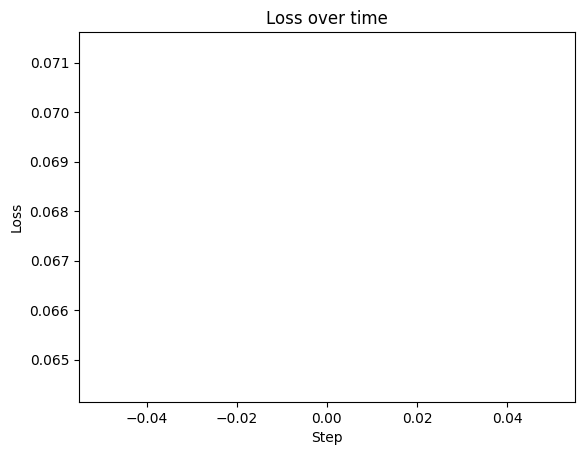

(1m 45s (- 0m 0s)) ([1] 100.00%) 0.0679


In [13]:
hidden_size = 256
input_size  = len(input_vocab)
output_size = len(label_to_i)

num_layers = 1
num_epochs = 1

attention = LuongAttention(hidden_size)
model = SequenceClassifier(input_size, hidden_size, num_layers, output_size, attention).to(device)
plot_losses = train(train_loader, model, num_epochs, print_every=1, plot_every=10)

In [37]:
len_epoch = len(plot_losses)
save_model(input_size, output_size, hidden_size, num_layers, model, plot_losses, f"nerd_lstm_selfattn_{len_epoch}.pth", len_epoch)

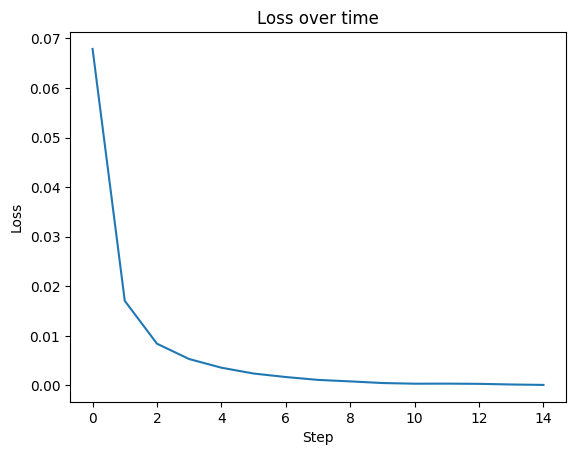

(9m 4s (- 0m 0s)) ([5] 100.00%) 0.0001


In [30]:
num_epochs = 5
plot_losses = train(train_loader, model, num_epochs, print_every=1, plot_every=1, plot_losses=plot_losses)

In [5]:
plot_losses, model = load_model('nerd_lstm_selfattn_15.pth')

In [12]:
val_loader      = DataLoader(test_dataset,  batch_size=1024, shuffle=False, drop_last=True)

In [38]:
def test_single_sample(idx, model, val_loader, input_vocab):    
    # Set the model to evaluation mode
    model.eval()
    
    input_tensor_org, target_tensor = val_loader.dataset[idx]
    input_tensor = input_tensor_org.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        
    # Get the predicted class indices
    _, predicted_indices = torch.max(output, dim=2)
    
    seq_str = [input_vocab.itos[idx] for idx in input_tensor_org.tolist()]
    lab_str = [i_to_label[idx] for idx in target_tensor.tolist()]
    pred_str = [i_to_label[idx] for idx in predicted_indices.squeeze(0).tolist()]

    return seq_str, lab_str, pred_str

def inference_one(input_str, input_vocab, model):
    input_tokenized = tokenize_string(input_str)
    print(input_tokenized)
    tokenized = numericalize_list(input_tokenized, input_vocab)

    toknied = dash_recovery(input_tokenized, tokenized)
            
    toknied_numed = numericalize_list(toknied, input_vocab)
    tokenized = toknied_numed
    print(f"{tokenized=}")
    input_pad   = np.full(shape=max_len_inp, fill_value=2, dtype=np.int32)
    input_pad[0:len(tokenized)] = tokenized
    inp_token = torch.tensor(input_pad, dtype=torch.long).to(device)
    input_tensor = inp_token.unsqueeze(0).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
    
    # Get the predicted class indices
    _, predicted_indices = torch.max(output, dim=2)
    lab_str = [i_to_label[idx] for idx in predicted_indices.squeeze(0).tolist()]
    
    tokenized_str = [input_vocab.itos[idx] for idx in tokenized]
    
    return tokenized_str, lab_str

def evaluate(model, val_loader):
    
    true_labels = []
    predicted_labels = []
    
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate over the validation data
    total_steps = len(val_loader)
    with torch.no_grad():
        for step, (input_tensor, target_tensor) in tqdm.tqdm(enumerate(val_loader), total=total_steps):
            # Forward pass
            output = model(input_tensor)
            
            # Get the predicted class indices
            _, predicted_indices = torch.max(output, dim=2)
            
            # Get the true labels
            for i in target_tensor.cpu().numpy().tolist():
                true_labels.extend(i)
            for i in predicted_indices.cpu().numpy().tolist():
                predicted_labels.extend(i)
            break
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0.0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0.0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }
    
def tag_formatter(words, tags, split=20):
    lens = [max(len(a), len(b)) for a, b in zip(words, tags)]

    # Use string formatting to create the output strings
    output_words = ' '.join(f"{word:<{lens[i]}}" + ("\n" * (i % split == 0 and i != 0))  for i, word in enumerate(words))
    output_tags = ' '.join(f"{tag:<{lens[i]}}" + ("\n" * (i % split == 0 and i != 0)) for i, tag in enumerate(tags[:len(words)]))
    
    return output_words.split("\n"), output_tags.split("\n")

def simple_val_samp(idx):
    seq, lab, pred = test_single_sample(idx, model, val_loader, input_vocab)

    print(f"Input: {seq}")
    print(f"Truth: {lab}")
    print(f"Preds: {pred}")

    print(f"Ground truth: {res_parser(seq, lab)}")
    print(f"Prediction  : {res_parser(seq, pred)}")
        
    output_words, output_tags = tag_formatter(seq[:seq.index('</s>')+1], pred)
    print()
    
    for out_word, out_tag in zip(output_words, output_tags):
        print(out_word)
        print(out_tag)
        print()
    
def simple_str_infer(input_str):
    print(input_str)
    tokenized, lab_str = inference_one(input_str, input_vocab, model)


    print(res_parser(tokenized, lab_str))
    print()
    output_words, output_tags = tag_formatter(tokenized, lab_str)

    print()
    
    for out_word, out_tag in zip(output_words, output_tags):
        print(out_word)
        print(out_tag)
        print()


In [19]:
metrics = evaluate(model, val_loader)
print(metrics['accuracy'])

  0%|          | 0/32 [00:00<?, ?it/s]


0.9971683773535565


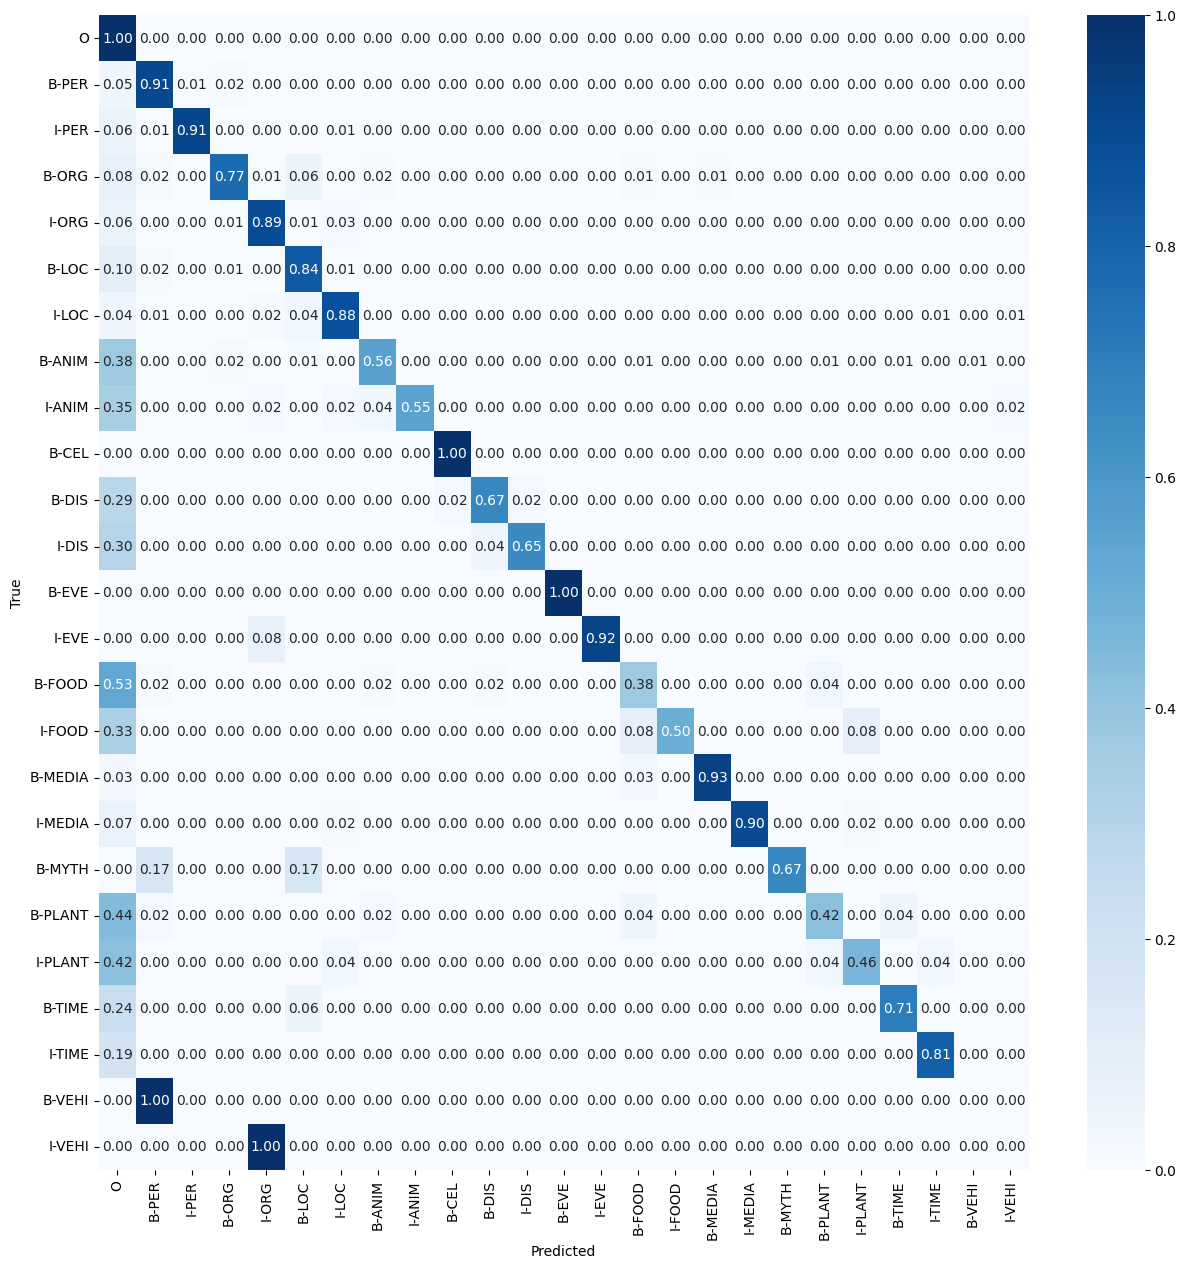

In [33]:
# Compute confusion matrix
labels = list(set(metrics['true_labels']).intersection(set(metrics['predicted_labels'])))  # get the intersection of unique labels in true and predicted labels
labels_names = [i_to_label[label] for label in labels]  # convert label indices to names
cm = confusion_matrix(metrics['true_labels'], metrics['predicted_labels'], labels=labels, normalize='true')
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='.02f', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
simple_val_samp(254)

Input: ['<s>', 'There', 'are', 'some', 'invertebrates', 'recorded', ',', 'including', 'for', 'marsh', 'fritillary', '(', '"', 'Euphydryas', 'aurinia', '"', ')', 'and', 'small', 'heath', '(', '"', 'Coenonympha', 'pamphilus', '"', ')', 'butterflies', ',', 'and', 'a', 'number', 'of', 'downland', 'birds', 'are', 'present', 'including', 'for', 'the', 'skylark', ',', 'corn', 'bunting', 'and', 'grey', 'partridge', '.', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', 

In [39]:
input_str = "Amelia Earhart flew her single engine Lockheed Vega 5B across the Atlantic to Paris."
simple_str_infer(input_str)

print()

input_str = "Donald Trump leads Joe Biden among young people"
simple_str_infer(input_str)

Amelia Earhart flew her single engine Lockheed Vega 5B across the Atlantic to Paris.
['Amelia', 'Earhart', 'flew', 'her', 'single', 'engine', 'Lockheed', 'Vega', '5B', 'across', 'the', 'Atlantic', 'to', 'Paris', '.']
tokenized=[0, 25509, 25510, 21186, 306, 170, 21821, 48507, 35467, 3, 2992, 8, 2747, 31, 10366, 13, 2]
{'B-PER': ['Amelia'], 'I-PER': ['Earhart'], 'B-MEDIA': ['Lockheed'], 'I-MEDIA': ['Vega', '<unk>'], 'B-LOC': ['Atlantic', 'Paris']}


<s> Amelia Earhart flew her single engine Lockheed Vega    <unk>   across the Atlantic to Paris . </s>
O   B-PER  I-PER   O    O   O      O      B-MEDIA  I-MEDIA I-MEDIA O      O   B-LOC    O  B-LOC O O   


Donald Trump leads Joe Biden among young people
['Donald', 'Trump', 'leads', 'Joe', 'Biden', 'among', 'young', 'people']
tokenized=[0, 4883, 18383, 14563, 1023, 67144, 235, 6239, 3661, 2]
{'B-PER': ['Donald', 'Joe'], 'I-PER': ['Trump', 'Biden']}


<s> Donald Trump leads Joe   Biden among young people </s>
O   B-PER  I-PER O     B-PER I-PE